# 0.0. Imports

In [64]:
import os
import psycopg2 as pg
import pandas.io.sql  as psql

import numpy       as np
import pandas      as pd
import boruta      as bt
import scikitplot  as skplt
import scipy.stats as ss
import pickle


import seaborn as sns

from matplotlib import pyplot as plt

from sklearn  import preprocessing   as pp
from sklearn  import linear_model    as lm
from sklearn  import model_selection as ms
from sklearn  import ensemble        as en
from sklearn  import neighbors       as nh
from lightgbm import LGBMClassifier



%matplotlib inline
from IPython.core.display  import HTML

## 0.1. Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v   

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict
    
def concat_order_data( x_val, y_val, yhat ):
    
    # copy data
    data = x_val.copy()
    data['response'] = y_val.copy()

    # propensity score
    data['score'] = yhat[:, 1].tolist()

    # sorted clients by propensity score
    data = data.sort_values( 'score', ascending=False )
    
    return data

def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


# all at k metrics as dataframe
def at_k_metrics( model_name, x_val, y_val, yhat, k=20000 ):
    data = concat_order_data( x_val, y_val, yhat )
    
    pr = precision_at_k( data, k )
    re = recall_at_k( data, k )
    
    return pd.DataFrame({"Precision_at_k": "{}".format(np.round(pr,3)),
                         "Recall_at_k": "{}".format(np.round(re,3))}, index=[model_name])
    


In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Get Data from Database

In [24]:
# Credenciais do Banco de dados Postgress
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database =  'comunidadedsdb'
username =  'member'
pwd = 'cdspa'

# Acessando os dados com SQL
conn = pg.connect( user=username,
                   password=pwd,
                   host=host,
                   port=port,
                   database=database ) 


# # create a cursor
cursor = conn.cursor()
query ='''
SELECT *
FROM pa004.users u inner join pa004.vehicle v on (u.id=v.id)
                   inner join pa004.insurance i on (u.id = i.id)
'''

cursor.execute( query )
print("Selecting rows from pa004 table using cursor.fetchall ended")
pa_records = cursor.fetchall()

df = pd.read_sql( query, conn )  
    
# close the connection
conn.close()

# slave data
df.to_csv( '/home/cassiano/repos/health_insurance_cross_sell/data/train.csv', index = False )

Selecting rows from pa004 table using cursor.fetchall ended


/opt/anaconda/envs/health-insurance/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## 0.3. Load dataset

In [4]:
df_raw = pd.read_csv ('/home/cassiano/repos/health_insurance_cross_sell/data/train.csv')


# 1.0. Data Description

In [5]:
df_aux = df_raw.copy()

df_aux = df_aux.drop(df_aux.columns[[5, 9]], axis=1)
df_aux.shape

(381109, 12)

## 1.1. Rename Columns

In [6]:
df_aux = df_aux[['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']]

## 1.2 Split Data into Training / Validation

In [7]:
X_test = df_aux.drop(['response'], axis = 1)
y_test = df_aux['response'].copy()

df0, X_test, y0, y_test = ms.train_test_split(X_test,y_test,test_size=0.2)

df0 = pd.concat([df0, y0], axis = 1)

In [8]:
df_test = X_test
df_test.to_csv('/home/cassiano/repos/health_insurance_cross_sell/data/df_test.csv')

In [9]:
df1 = df0.copy()

## 1.2. Data Dimensions

In [10]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 304887
Number of Columns: 12


## 1.3. Data Types

In [11]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Check Balanced Data

In [13]:
df1['response'].value_counts(normalize=True)

0    0.877184
1    0.122816
Name: response, dtype: float64

A maioria dos clientes respondeu que não tem interesse em um seguro de carro. Apenas 12% responderam 'sim' na pesquisa. 

### Columns Description

   * Id: Customer identifier
   * Gender: Gender of customer
   * Age: Age of customer
   * Driving License: 0 if customer does not have the permission for drive; 1 if customer has the permission for drive
   * Region Code: Region code of customer
   * Previously Insured: 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.
   * Vehicle Age: Age of vehicle
   * Vehicle Damage: 0 if customer never got involved in a previous vehicle damage; 1 if customer already had a vehicle damage
   * Annual Premium: amount paid for health insurance to the company anualy.
   * Policy sales channel: anonymous code for contact with customer.
   * Vintage: time (in days) that customer bought his health assurance.
   * Response: 0 if customer has no interest in product; 1 if customer has interest in product

## 1.6. Data Descriptive

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [15]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T  
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190768.279599,190893.0,110001.936546,-0.002000,-1.199731
1,age,20.0,85.0,65.0,38.806181,36.0,15.507255,0.674149,-0.562708
2,driving_license,0.0,1.0,1.0,0.997907,1.0,0.045697,-21.791881,472.889182
3,region_code,0.0,52.0,52.0,26.386956,28.0,13.234837,-0.115590,-0.869628
4,previously_insured,0.0,1.0,1.0,0.458019,0.0,0.498234,0.168520,-1.971614
5,annual_premium,2630.0,540165.0,537535.0,30550.450682,31651.0,17209.993325,1.668865,31.370236
6,policy_sales_channel,1.0,163.0,162.0,112.081017,135.0,54.188270,-0.901679,-0.967454
7,vintage,10.0,299.0,289.0,154.452961,154.0,83.664689,0.000675,-1.200813
8,response,0.0,1.0,1.0,0.122816,0.0,0.328226,2.298331,3.282347


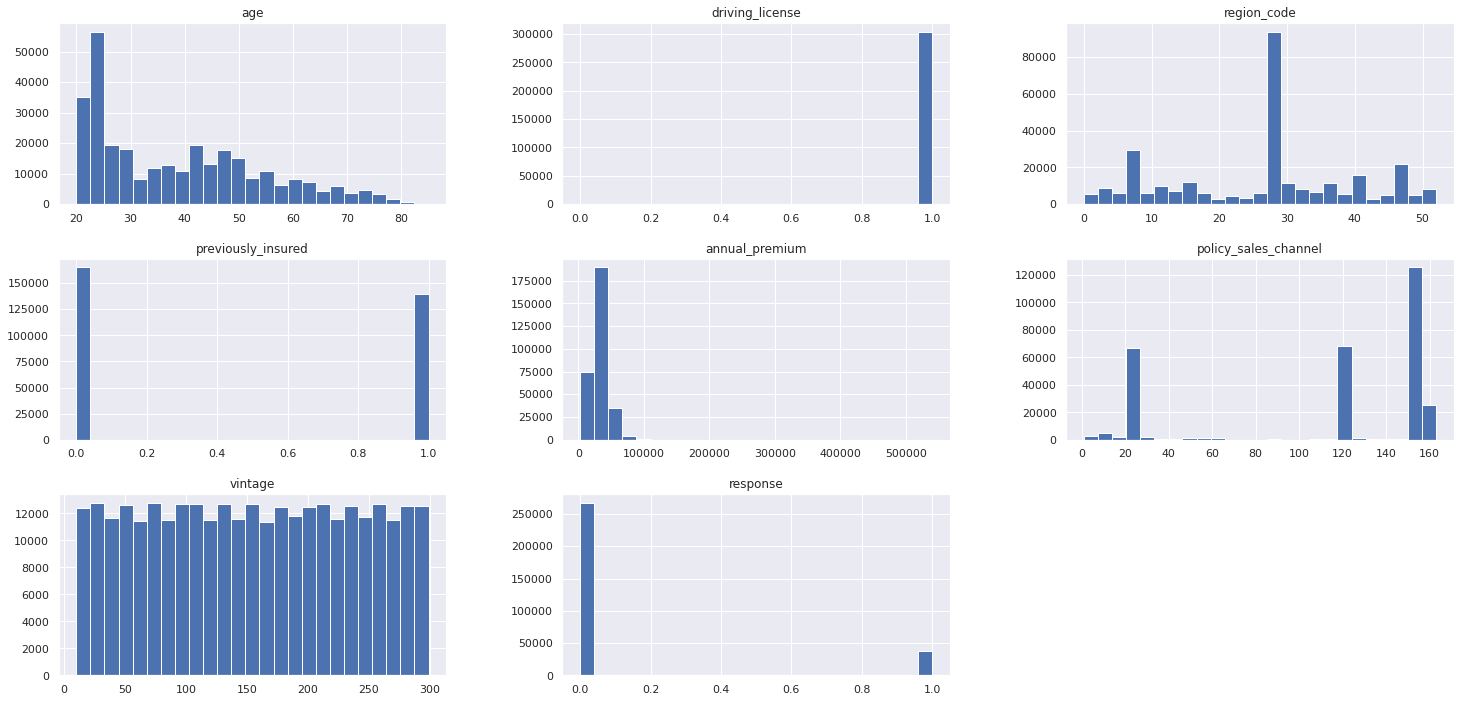

In [16]:
num_attributes.drop(columns = ['id'], inplace = True)
num_attributes.hist(bins=25);

## 1.7. Categorical Attributes

In [17]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164780,160274,153948


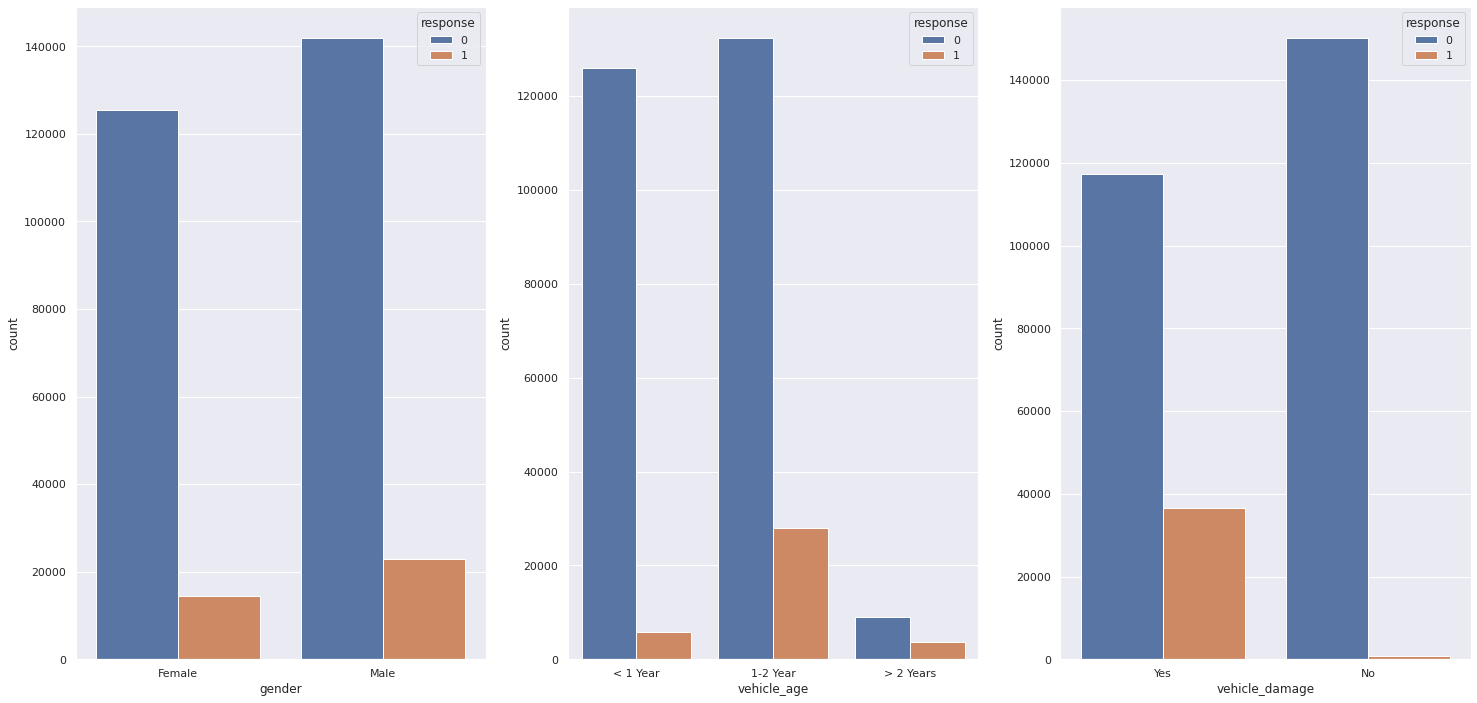

In [18]:
plt.subplot(1, 3, 1)
sns.countplot(data=df1, x='gender', hue='response');
plt.subplot(1, 3, 2)
sns.countplot(data=df1, x='vehicle_age', hue='response');

plt.subplot(1, 3, 3)
sns.countplot(data=df1, x='vehicle_damage', hue='response');

# 2.0. Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Hypotheses Mindmap

## 2.2. Hypothesis

H1 - Mulheres tem mais interesse em comprar seguro de veículos que homens.

H2 - Clientes com carros novos/seminovos, tem mais interesse em seguro de veículos

H3 - Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos.

H4 - Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

H5 - Mulheres tem mais eventos de dano a veículos, do que homens.

## 2.3. Feature Engineering

In [20]:
# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                                                         else 'between_1_2_year' 
                                                                         if x == '1-2 Year' 
                                                                         else 'below_1_year' )           

# 3.0. Data Filtering

In [21]:
df3 = df2.copy()

# 4.0 Análise Exploratória dos Dados

In [22]:
df4 = df3.copy()

## 4.1. Univariate Analysis

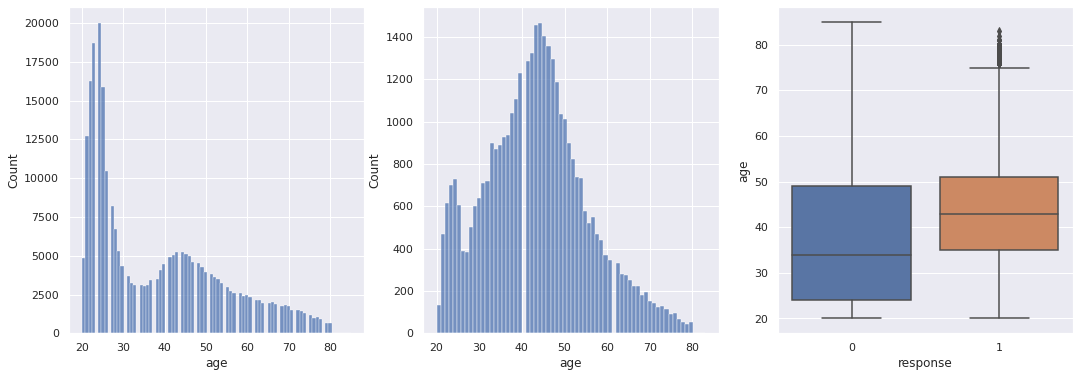

In [23]:
# age 
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
aux1 = df4.loc[df4['response'] == 0, 'age' ]
sns.histplot( aux1 )

plt.subplot(1, 3, 2)
aux2 = df4.loc[df4['response'] == 1, 'age' ]
sns.histplot( aux2 )

plt.subplot(1, 3, 3)
sns.boxplot( x='response', y='age', data=df4);

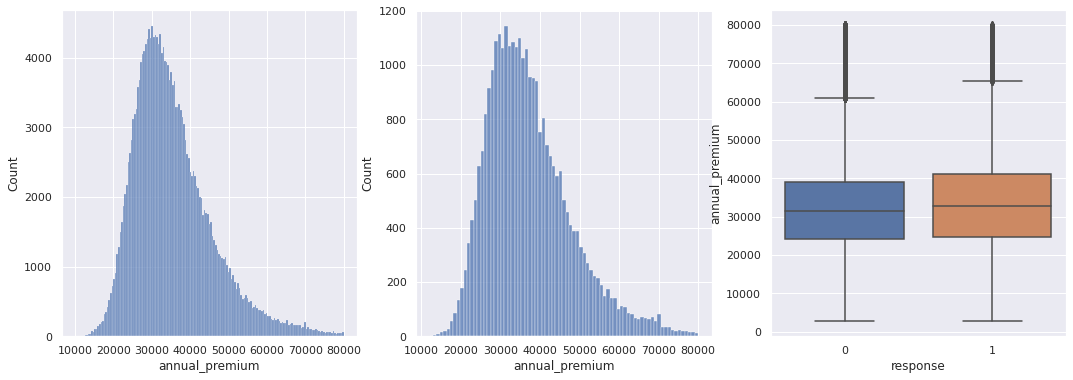

In [24]:
# annual_premium
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
aux = df4[(df4['annual_premium'] > 10000 ) &(df4['annual_premium'] < 80000)]
aux1 = aux.loc[aux['response'] == 0, 'annual_premium' ]
sns.histplot( aux1 )

plt.subplot(1, 3, 2)
aux2 = aux.loc[aux['response'] == 1, 'annual_premium' ]
sns.histplot( aux2 )

plt.subplot(1, 3, 3)
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux);

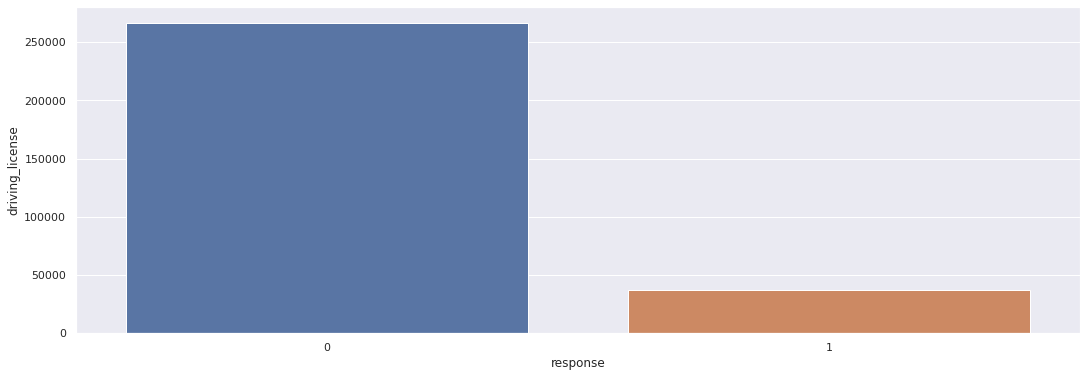

In [25]:
# driving_license
plt.figure(figsize=(18, 6))
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux);

In [26]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux['driving_license_%'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,response,driving_license,driving_license_%
0,0,266837,0.877035
1,1,37412,0.122965


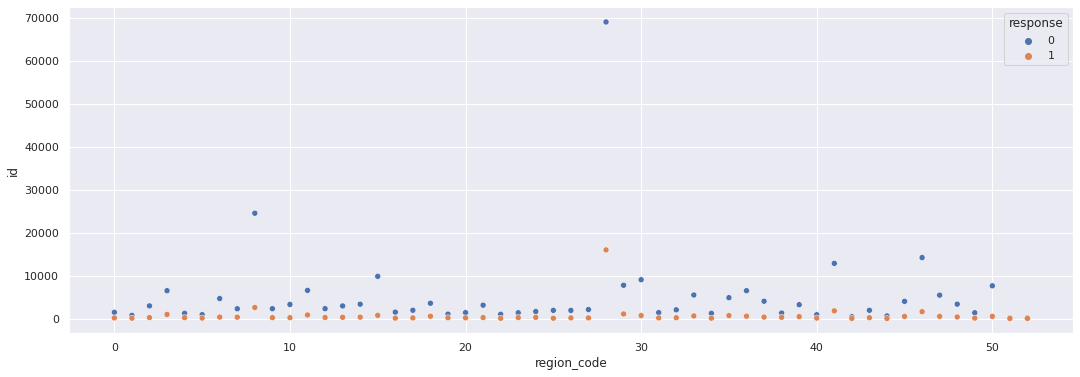

In [27]:
# region_code
plt.figure(figsize=(18, 6))
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0);

In [28]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774157,0.225843
1,0.999098,0.000902


In [29]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434253
1,below_1_year,0,0.413448
2,between_1_2_year,1,0.091431
3,over_2_years,0,0.029483
4,below_1_year,1,0.018984
5,over_2_years,1,0.012401


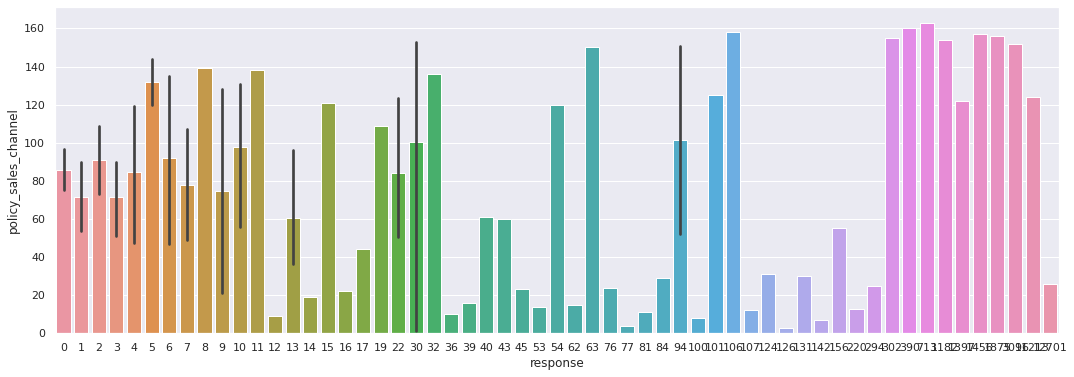

In [30]:
# policy_sales_channel
plt.figure(figsize=(18, 6))
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux);

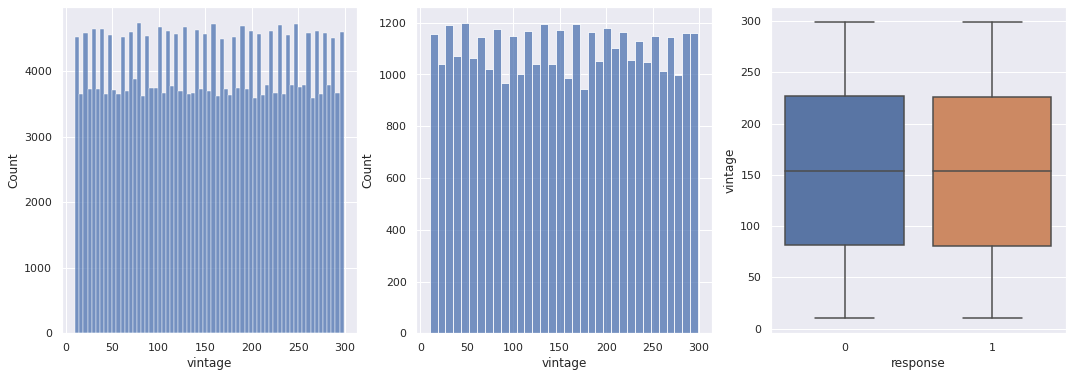

In [31]:
plt.figure( figsize=(18, 6))

plt.subplot(1, 3, 1)
aux1 = df4.loc[df4['response'] == 0, 'vintage' ]
sns.histplot( aux1 )

plt.subplot(1, 3, 2)
aux2 = df4.loc[df4['response'] == 1, 'vintage' ]
sns.histplot( aux2 )

plt.subplot(1, 3, 3)
sns.boxplot( x='response', y='vintage', data=df4);

## 4.2 Bivariate Analysis

### H1 - Mulheres tem mais interesse em comprar seguro de veículos que homens.

Falsa Clientes homens tem maior probabilidade de adquirir seguro de automóvel.

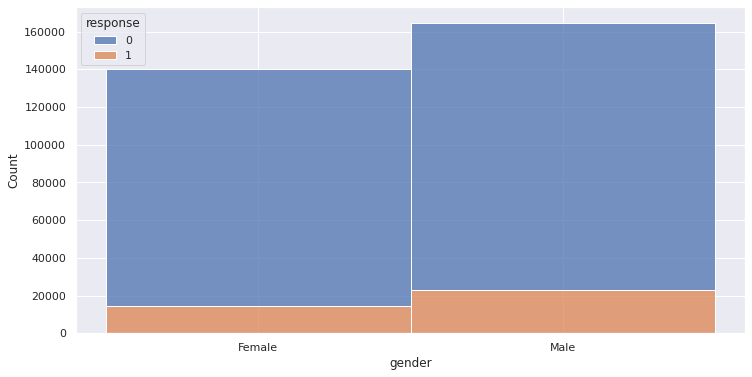

In [32]:
plt.figure( figsize=(12, 6))
sns.histplot(data=df4, x='gender', hue='response', multiple='stack');

### H2 - Clientes com carros novos/seminovos, tem mais interesse em seguro de veículos.

Verdadeira - Cliente com carros seminovos tem maior intere em adquirir um seguro de veículo

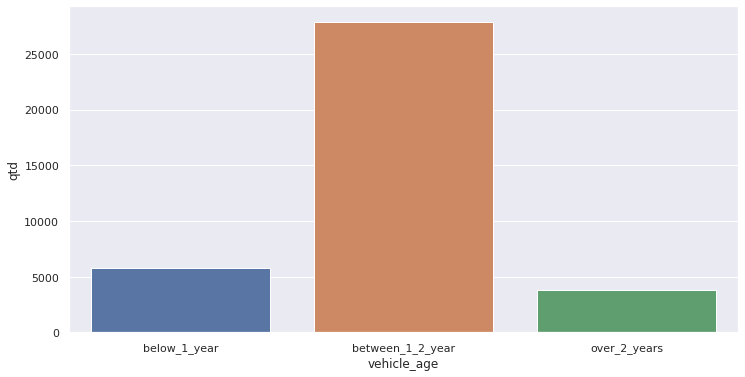

In [33]:
plt.figure( figsize=(12, 6))
aux=df4[df4['response']==1]
aux=aux[['vehicle_age']].groupby('vehicle_age').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='vehicle_age',y='qtd');
total=sum(aux['qtd'])

### H3 - Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos.

Verdadeira - clientes interessados tem mais que 30 anos de idade

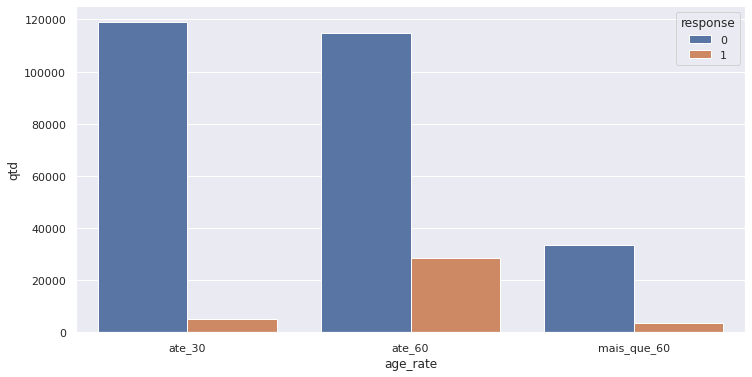

In [34]:
plt.figure( figsize=(12, 6))
aux=df4.copy()
aux['age_rate']=df4['age'].apply(lambda x: 'ate_30' if x<30 else 'ate_60' if x>=30 and x<60 else 'mais_que_60')
aux=aux[['age_rate','response']].groupby(['age_rate','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='age_rate',y='qtd',hue='response');
total=sum(aux['qtd'])

### H4 - Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

Verdadeira

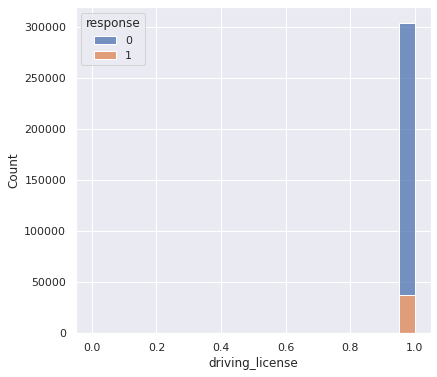

In [35]:
plt.figure( figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='driving_license', hue='response', multiple='stack');


### H5 - Mulheres tem mais eventos de dano a veículos, do que homens.

Falsa - Homens tem maior numero de eventos de dano à veículos.

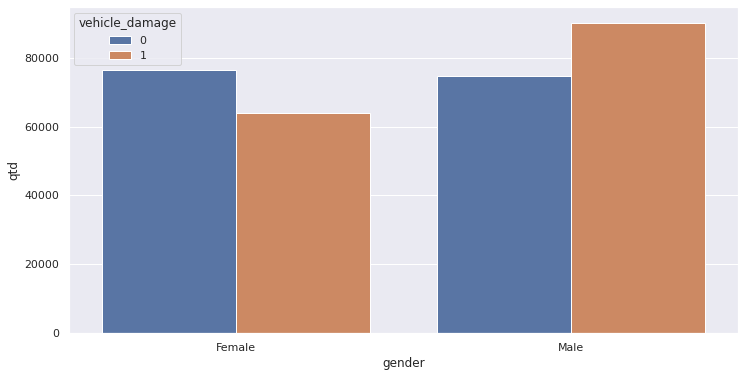

In [36]:
plt.figure( figsize=(12, 6))
aux=df4[['vehicle_damage','gender']].groupby(['vehicle_damage','gender']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

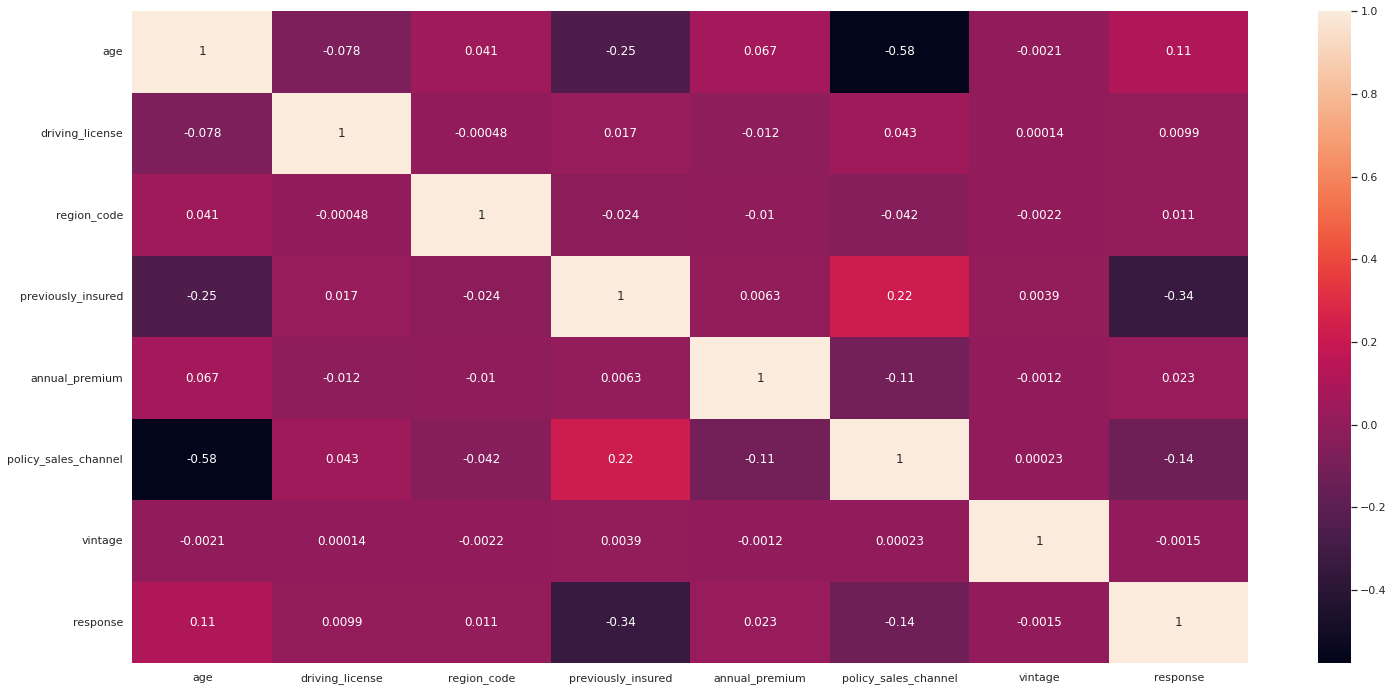

In [37]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.2. Categorical Attributes

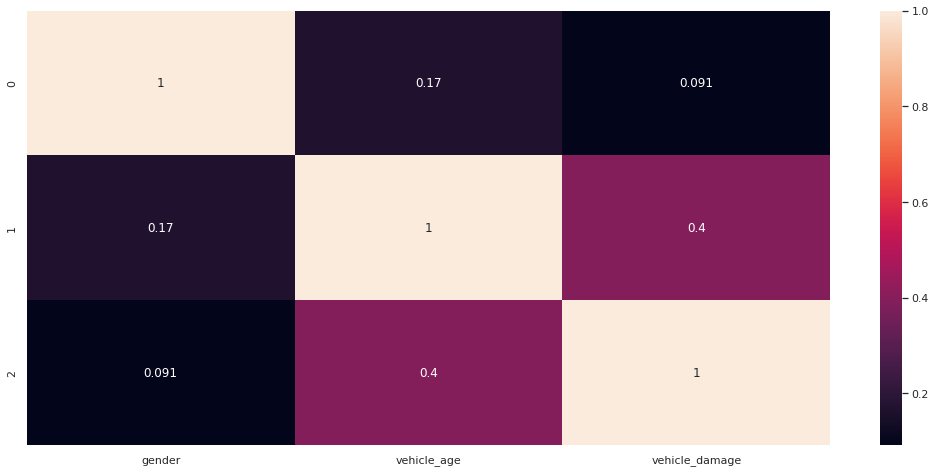

In [38]:
fig = plt.subplots(figsize = (18,8))
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

# 5.0. Data Preparation

In [39]:
df5 = df4.copy()

In [40]:
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [41]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
209498,148359,Female,23,1,15.0,0,below_1_year,1,33476.0,152.0,154,0
266532,224194,Female,31,1,46.0,0,between_1_2_year,0,19410.0,154.0,43,0
170482,218884,Male,59,1,28.0,0,between_1_2_year,1,32763.0,26.0,222,0
76375,227874,Female,38,1,28.0,0,between_1_2_year,1,44153.0,31.0,102,1
234909,351732,Male,22,1,7.0,1,below_1_year,0,58921.0,152.0,130,0


## 5.1. Standardization

In [42]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [43]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb'))

# vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1 One Hot Encoding

In [44]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

### 5.3.2 Targe Encoding

In [45]:
# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4. Train preparation

In [46]:
X = df5.drop( 'response', axis=1 )
y = df5['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

# 6.0. Feature Selection

## 6.2. Features Importancia

In [47]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.269908
0                annual_premium    0.239922
0                           age    0.167977
0                   region_code    0.106738
0                vehicle_damage    0.068654
0          policy_sales_channel    0.063052
0            previously_insured    0.055560
0      vehicle_age_below_1_year    0.014156
0  vehicle_age_between_1_2_year    0.005924
0                        gender    0.005264
0      vehicle_age_over_2_years    0.002365
0               driving_license    0.000481


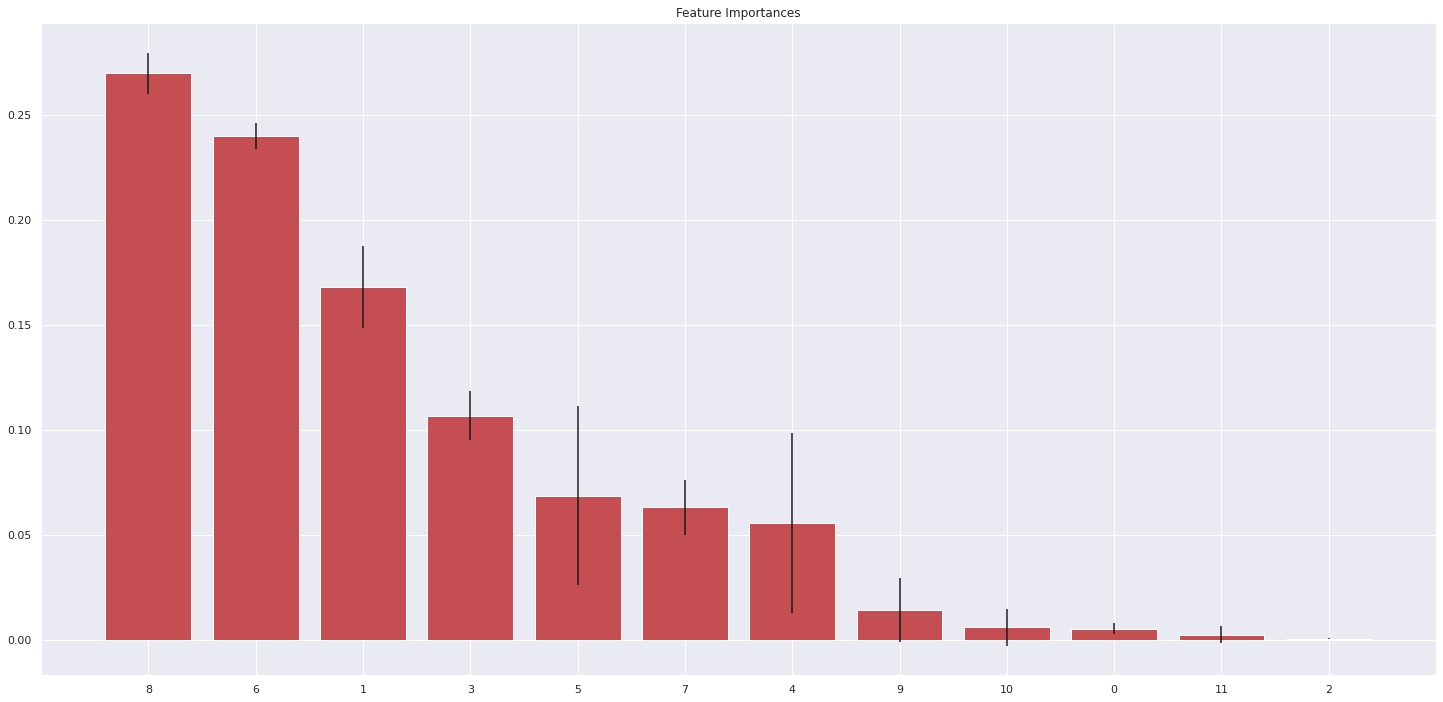

In [48]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show();

# 7.0. Machine Learning

In [49]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [50]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

## 7.1. KNN Classifier

In [51]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

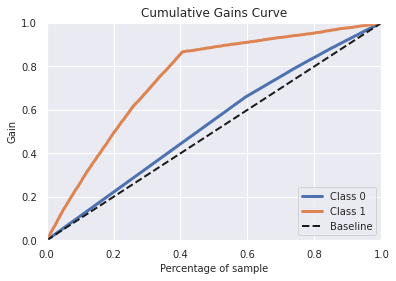

In [65]:
# Accumulative gain
skplt.metrics.plot_cumulative_gain( y_val,yhat_knn );

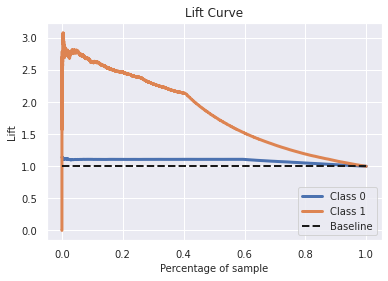

In [66]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2. Logistic Regressor

In [54]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

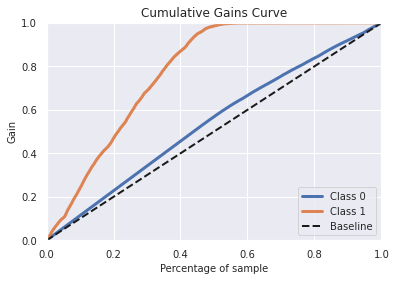

In [67]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

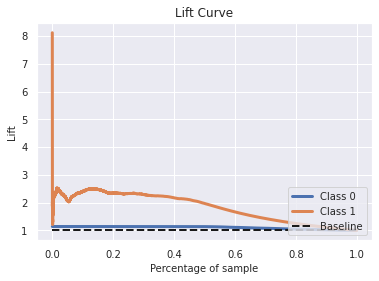

In [68]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.4. Random Forest

In [57]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

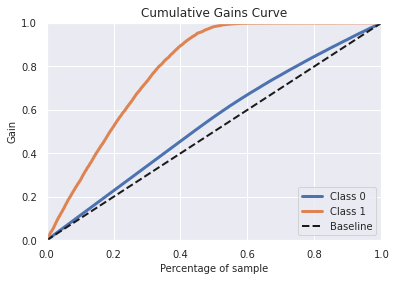

In [69]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

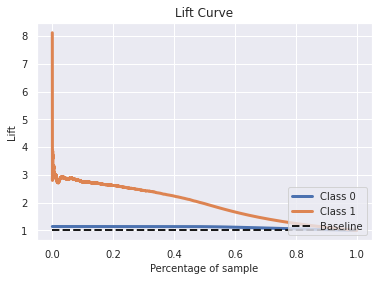

In [70]:
# scikitplot libary is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

## 7.5 LGBM

In [60]:
lgbm_model = LGBMClassifier()
#model training
lgbm_model.fit( x_train, y_train )

# prediction
yhat_lgbm = lgbm_model.predict_proba( x_val )

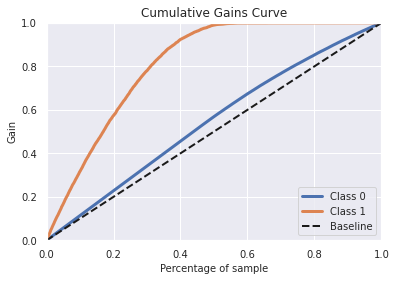

In [71]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm );

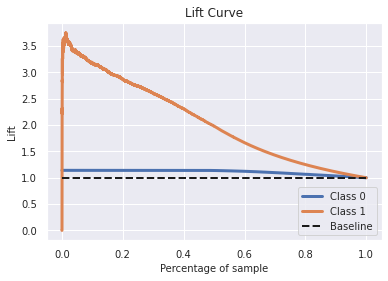

In [72]:
# scikitplot libary is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm );

## 7.6. Model Performance

In [63]:
aux1 = at_k_metrics( 'KNN', x_val, y_val, yhat_knn, k=50 )
aux2 = at_k_metrics( 'Logistic Regressor', x_val, y_val, yhat_lr,   k=50 )
aux3 = at_k_metrics( 'Random Forest', x_val, y_val, yhat_rf,   k=50 )
aux4 = at_k_metrics( 'LGBM Classifier', x_val, y_val, yhat_lgbm, k=50 )

results = pd.concat([aux1, aux2, aux3, aux4])
results.sort_values(by = 'Precision_at_k', ascending = True)

,Precision_at_k,Recall_at_k
Logistic Regressor,0.176,0.001
LGBM Classifier,0.275,0.002
KNN,0.314,0.002
Random Forest,0.412,0.003


# 8.0 Business Perfomance

## 8.1.  20.000 Calls

In [73]:
perc = 100*20000/len(y_val)

print('20.000 representa {:.2f}% da base de validação'.format(perc))

20.000 representa 32.80% da base de validação


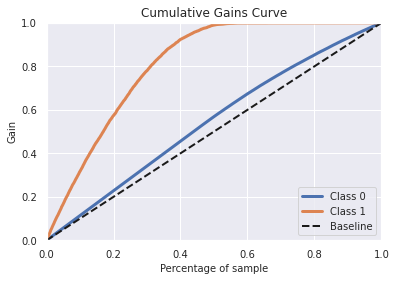

In [74]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm );

Ao analisar o ganho acumulado para 32% da base, alcançaremos aproximadamente 80% dos clientes interessados.

## 8.2. 40.000 Calls

   * E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?


In [75]:
perc = 100*40000/len(y_val)

print('40.000 representa {:.2f}% da base de validação'.format(perc))
print('Ao analisar o ganho acumulado para {:.2f}% da base, alcançaremos aproximadamente 100% dos clientes interessados.'.format(perc))

40.000 representa 65.60% da base de validação
Ao analisar o ganho acumulado para 65.60% da base, alcançaremos aproximadamente 100% dos clientes interessados.


# 9.0. Deploy to Production

In [79]:
# Save trained model
pickle.dump( lr_model, open( '/home/cassiano/repos/health_insurance_cross_sell/src/models/model_linear_regression.pkl', 'wb' ) )

## 9.1. Health Insurance Class

In [81]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance( object ):
    
    def __init__( self ):
        self.home_path = '/home/cassiano/repos/health_insurance_cross_sell/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [82]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
path = '/home/cassiano/repos/health_insurance_cross_sell/'
model = pickle.load( open( path + 'src/models/model_linear_regression.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def healthinsurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

ModuleNotFoundError: No module named 'healthinsurance'

## 9.3. API Tester

In [83]:
import requests

In [84]:
# loading test dataset
df_test=df_test.sample(10)
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
243640,41228,Female,43,1,36.0,0,1-2 Year,Yes,2630.0,152.0,39
215581,197423,Female,54,1,8.0,0,1-2 Year,Yes,26204.0,156.0,137
256233,142156,Male,35,1,43.0,0,1-2 Year,Yes,42524.0,26.0,100
189096,367428,Female,46,1,28.0,1,1-2 Year,No,40640.0,26.0,294
238041,377438,Female,54,1,50.0,1,1-2 Year,No,35823.0,124.0,176
74466,212727,Male,54,1,28.0,1,1-2 Year,No,54984.0,26.0,106
137205,334732,Female,25,1,32.0,1,< 1 Year,No,29015.0,152.0,201
43602,348162,Male,23,1,8.0,0,< 1 Year,Yes,2630.0,160.0,25
204765,110712,Female,53,1,28.0,0,1-2 Year,Yes,21828.0,26.0,236
156820,109417,Male,29,1,28.0,0,< 1 Year,Yes,22990.0,124.0,45


In [85]:
print( f'Number of Rows: {df_test.shape[0]}' )
print( f'Number of Columns: {df_test.shape[1]}' )

Number of Rows: 10
Number of Columns: 11


In [86]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [87]:
data

'[{"id": 41228, "gender": "Female", "age": 43, "driving_license": 1, "region_code": 36.0, "previously_insured": 0, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "annual_premium": 2630.0, "policy_sales_channel": 152.0, "vintage": 39}, {"id": 197423, "gender": "Female", "age": 54, "driving_license": 1, "region_code": 8.0, "previously_insured": 0, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "annual_premium": 26204.0, "policy_sales_channel": 156.0, "vintage": 137}, {"id": 142156, "gender": "Male", "age": 35, "driving_license": 1, "region_code": 43.0, "previously_insured": 0, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "annual_premium": 42524.0, "policy_sales_channel": 26.0, "vintage": 100}, {"id": 367428, "gender": "Female", "age": 46, "driving_license": 1, "region_code": 28.0, "previously_insured": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "No", "annual_premium": 40640.0, "policy_sales_channel": 26.0, "vintage": 294}, {"id": 377438, "gender": "Female", "age": 5

In [88]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-score.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [89]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head(20)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
9,109417,0.138840,0.138462,1,0.188007,0,below_1_year,1,-0.439306,124.0,0.121107,0.300952
8,110712,0.103971,0.507692,1,0.188007,0,between_1_2_year,1,-0.506825,26.0,0.782007,0.286643
7,348162,0.138840,0.046154,1,0.095108,0,below_1_year,1,-1.622339,160.0,0.051903,0.239822
1,197423,0.103971,0.523077,1,0.095108,0,between_1_2_year,1,-0.252554,156.0,0.439446,0.233017
2,142156,0.138840,0.230769,1,0.094322,0,between_1_2_year,1,0.695732,26.0,0.311419,0.215662
0,41228,0.103971,0.353846,1,0.079671,0,between_1_2_year,1,-1.622339,152.0,0.100346,0.178570
3,367428,0.103971,0.400000,1,0.188007,1,between_1_2_year,0,0.586261,26.0,0.982699,0.000926
5,212727,0.138840,0.523077,1,0.188007,1,between_1_2_year,0,1.419730,26.0,0.332180,0.000910
6,334732,0.103971,0.076923,1,0.086215,1,below_1_year,0,-0.089219,152.0,0.660900,0.000535
4,377438,0.103971,0.523077,1,0.063788,1,between_1_2_year,0,0.306366,124.0,0.574394,0.000514


# 10.0. Google Sheets App - Script

In [ ]:
function onOpen(){
  var ui = SpreadsheetApp.getUi();
  ui.createMenu( 'Health Insurance Prediction' )
    .addItem( 'Get Prediction', 'PredictAll')
    .addToUi(); 
}

host_production = 'health-insurance-score.herokuapp.com'

// Help fuction
function ApiCall( data, endpoint ){
  var url = 'https://' + host_production + endpoint;
  var payload = JSON.stringify( data );

  var options = {'method': 'POST', 'contentType': 'application/json', 'payload': payload};

  var response = UrlFetchApp.fetch( url, options );

  //get response
  var rc = response.getResponseCode();
  var responseText = response.getContentText();

  if ( rc !== 200){
    Logger.log( 'Response (%s) %s', rc, responseText);
  }

  else{
    prediction = JSON.parse( responseText );
  }

  return prediction


};

function PredictAll(){
  var ss = SpreadsheetApp.getActiveSheet();
  var titleColumns = ss.getRange( 'A1:k1').getValues()[0];
  var lastRow = ss.getLastRow();

  var data = ss.getRange( 'A2' + ':' + 'K' + lastRow ).getValues();

  // run over all rows
  for ( row in data ){
    var json = new Object();


     // run over all columns
     for( var j=0; j < titleColumns.length; j++ ){
       json[titleColumns[j]] = data[row][j];
     };

    // List of Json to Send
    var json_send = new Object();
    json_send['id'] = json['id']
    json_send['gender'] = json['gender']
    json_send['age'] = json['age']
    json_send['driving_license'] = json['driving_license']
    json_send['region_code'] = json['region_code']
    json_send['previously_insured'] = json['previously_insured']
    json_send['vehicle_age'] = json['vehicle_age']
    json_send['vehicle_damage'] = json['vehicle_damage']
    json_send['annual_premium'] = json['annual_premium']
    json_send['policy_sales_channel'] = json['policy_sales_channel']
    json_send['vintage'] = json['vintage']

    pred = ApiCall( json_send, '/predict');


    // Send back to google sheets
    ss.getRange( Number( row ) + 2, 12 ).setValue( pred[0]['score'])

  };
};
